# Title: Sms Spam Detection

# Overview

- The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.
- The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

# Objective

 - Build a prediction model that will accurately classify which texts are spam.


# Import the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB ,MultinomialNB,BernoulliNB

import warnings
warnings.filterwarnings('ignore')

# Load the Dataset and view the dataset

In [2]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding = 'latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#Display the shape of the dataset
df.shape

(5572, 5)

The dataset has 5572 rows and 5 columns

In [4]:
#Dispaly more information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Display the columns in the dataset
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
#Check for missing values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
# Drop the necessary columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
#renaming the columns
df.rename(columns={'v1':'output','v2':'sms/email'},inplace=True)
df

,output,sms/email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
#Checking for missing values
df.isnull().sum()

output       0
sms/email    0
dtype: int64

In [10]:
# Check for the statistics
df.describe().T

,count,unique,top,freq
output,5572,2,ham,4825
sms/email,5572,5169,"Sorry, I'll call later",30


In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates(keep='first')

In [13]:
df.duplicated().sum()

0

In [14]:
df.apply(lambda x: len(x.unique()))

output          2
sms/email    5169
dtype: int64

# Exploratory Data Analysis

(array([0, 1]), [Text(0, 0, 'ham'), Text(1, 0, 'spam')])

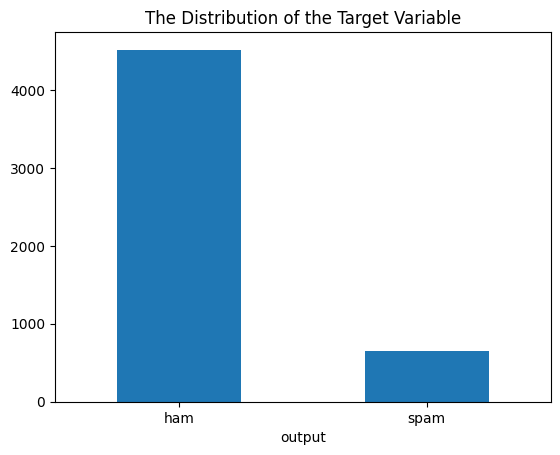

In [15]:
df["output"].value_counts().plot(kind = "bar")
plt.title('The Distribution of the Target Variable')
plt.xticks(rotation = 0)

In [16]:
# Converting 'ham' to 0 and 'spam' to 1 (encoding)
df['output'] = df['output'].map({'ham': 0, 'spam': 1})
df['output'].head()

0    0
1    0
2    1
3    0
4    0
Name: output, dtype: int64

In [17]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
#get number of characters in each sms
df['num_of_chars']=df['sms/email'].apply(len)
df.head()

,output,sms/email,num_of_chars
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


Tokenizing is a fundamental step in natural language processing (NLP) where text is split into smaller units, such as words, phrases, or even characters. This process is crucial for analyzing and processing textual data.
Word Tokenization: Splitting text into individual words

In [19]:
tokenized_sms = []
length_of_sms = []

for sms in df['sms/email']:
    tokens = nltk.word_tokenize(sms)
    tokenized_sms.append(tokens)
    length_of_sms.append(len(tokens))


df['tokenized_sms'] = tokenized_sms
df['num_of_words'] = length_of_sms

df.head()

,output,sms/email,num_of_chars,tokenized_sms,num_of_words
0,0,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy.., Availab...",23
1,0,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",37
3,0,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15


In [20]:
num_sentences = []

for sms in df['sms/email']:
    sentences = sent_tokenize(sms)
    num_sentences.append(len(sentences))


df['num_of_sent'] = num_sentences

df.head()

,output,sms/email,num_of_chars,tokenized_sms,num_of_words,num_of_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy.., Availab...",23,2
1,0,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",37,2
3,0,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15,1


In [21]:
#describe these 3 cols to get more info 

df[['num_of_chars','num_of_words','num_of_sent']].describe()

,num_of_chars,num_of_words,num_of_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.286129,1.961308
std,58.236293,13.226400,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,219.000000,38.000000


In [22]:
# describe these cols for spam sms/email
df[df['output']==1][['num_of_chars','num_of_words','num_of_sent']].describe()

,num_of_chars,num_of_words,num_of_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


In [23]:
# describe these cols for spam sms/email
df[df['output']==1][['num_of_chars','num_of_words','num_of_sent']].describe()

,num_of_chars,num_of_words,num_of_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


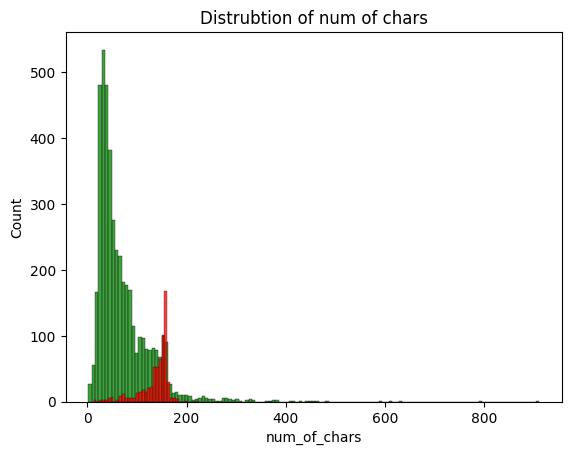

In [24]:
# A distribution plot of the number of chars
sns.histplot(df[df['output']==0]['num_of_chars'],color='green')
sns.histplot(df[df['output']==1]['num_of_chars'],color='red')
plt.title('Distrubtion of num of chars')
plt.show()

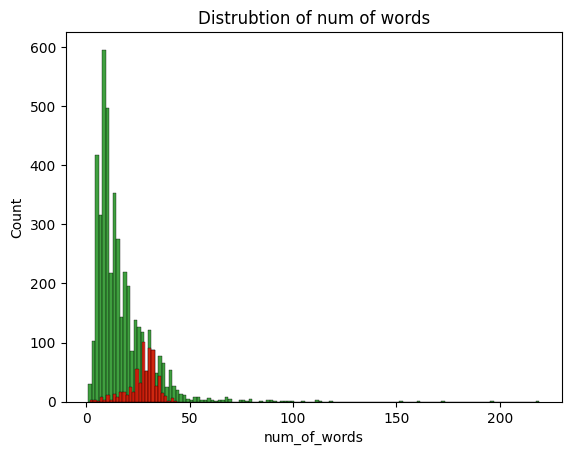

In [25]:
# A plot showing Distrubtion of number of words
sns.histplot(df[df['output']==0]['num_of_words'],color='green')
sns.histplot(df[df['output']==1]['num_of_words'],color='red')
plt.title('Distrubtion of num of words')
plt.show()

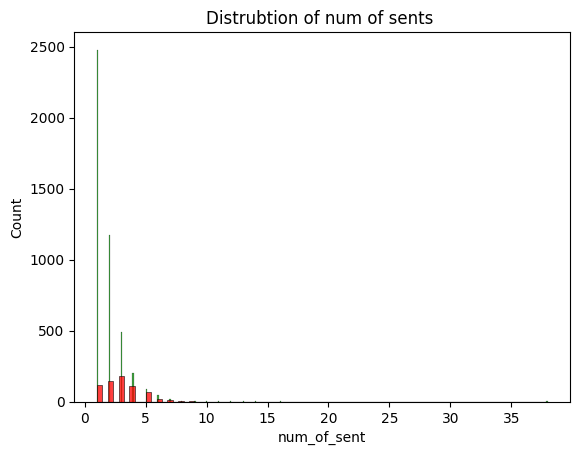

In [26]:
# A plot Showing the distribution of the number of senta
sns.histplot(df[df['output']==0]['num_of_sent'],color='green')
sns.histplot(df[df['output']==1]['num_of_sent'],color='red')
plt.title('Distrubtion of num of sents ')
plt.show()

In [27]:
df1=df[['output','num_of_chars','num_of_words','num_of_sent']]
df1.head()

,output,num_of_chars,num_of_words,num_of_sent
0,0,111,23,2
1,0,29,8,2
2,1,155,37,2
3,0,49,13,1
4,0,61,15,1


# Visualize the Correlation
- Positive Correlation

In [28]:
df1.corr()['output'].sort_values()[df1.corr()['output'].sort_values() > 0]

num_of_words    0.264198
num_of_sent     0.267602
num_of_chars    0.384717
output          1.000000
Name: output, dtype: float64

- Negative Correlation

In [29]:
df1.corr()['output'].sort_values()[df1.corr()['output'].sort_values() < 0]

Series([], Name: output, dtype: float64)

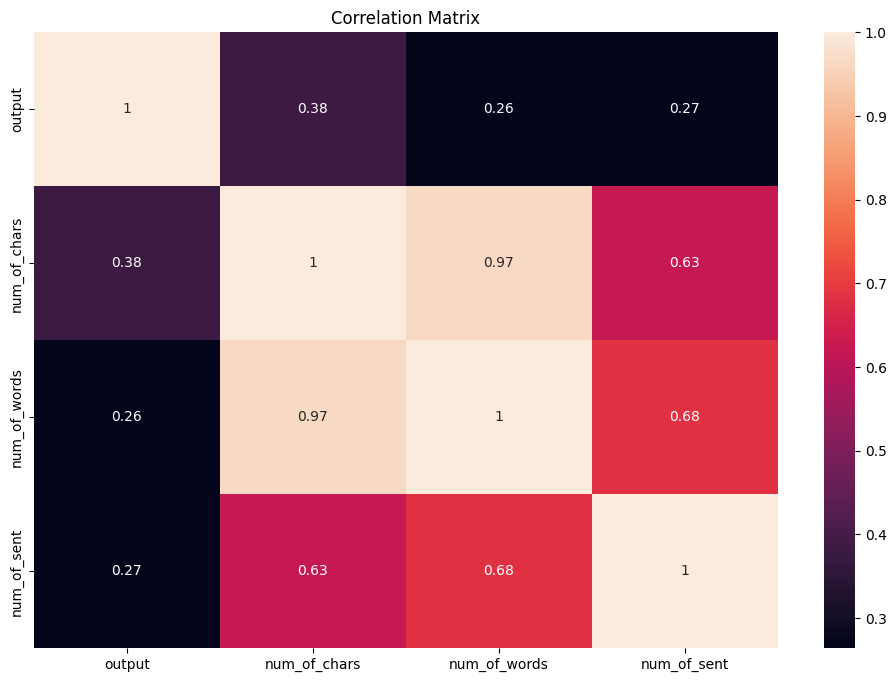

In [30]:
corr_matrix = df1.corr()
plt.figure(figsize= (12,8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

- string.punctuation: is useful for tasks such as text preprocessing, where you might want to remove or handle punctuation characters specifically

In [31]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PorterStemmer is an algorithm for stemming

In [32]:
ps=PorterStemmer()
ps.stem('dancing')

'danc'

- stopwords list of common stopwords that arry little meaningful content

In [33]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
def process_txt(txt):
    # convert all sms to lower case letters
    txt=txt.lower() 
    txt=nltk.word_tokenize(txt)
    
    y=[]
    for i in txt: 
        if i.isalnum()==True:
            y.append(i)
    txt=y[:]
    y.clear()
    
    for i in txt:
        if i not in stopwords.words('english')and i not in string.punctuation: # ignore stopwords & punctuation
            y.append(i)
    txt=y[:]
    y.clear()
    for i in txt:
        y.append(ps.stem(i)) 
    
    
    return " ".join(y)

In [35]:
print(df['sms/email'][2000])
print('_'*100)
print(process_txt(df['sms/email'][2000]))

But i'll b going 2 sch on mon. My sis need 2 take smth.
____________________________________________________________________________________________________
b go 2 sch mon si need 2 take smth


In [36]:
txt="hello 20 %"
process_txt(txt)

'hello 20'

In [37]:
df['text_transform']=df['sms/email'].apply(process_txt)
df.head()

,output,sms/email,num_of_chars,tokenized_sms,num_of_words,num_of_sent,text_transform
0,0,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy.., Availab...",23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15,1,nah think goe usf live around though


In [38]:
wc=WordCloud(width=500,height=500,min_font_size=10,min_word_length=4,background_color='black')
wc

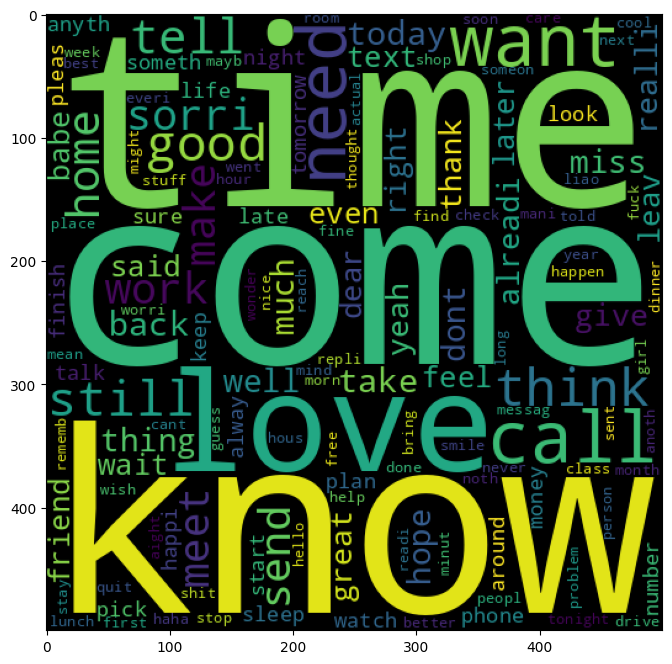

In [39]:
# Visualize the most frequently ham words
plt.figure(figsize = (12,8))
ham_words=wc.generate(df[df['output']==0]['text_transform'].str.cat(sep=" "))
plt.imshow(ham_words)
plt.show()

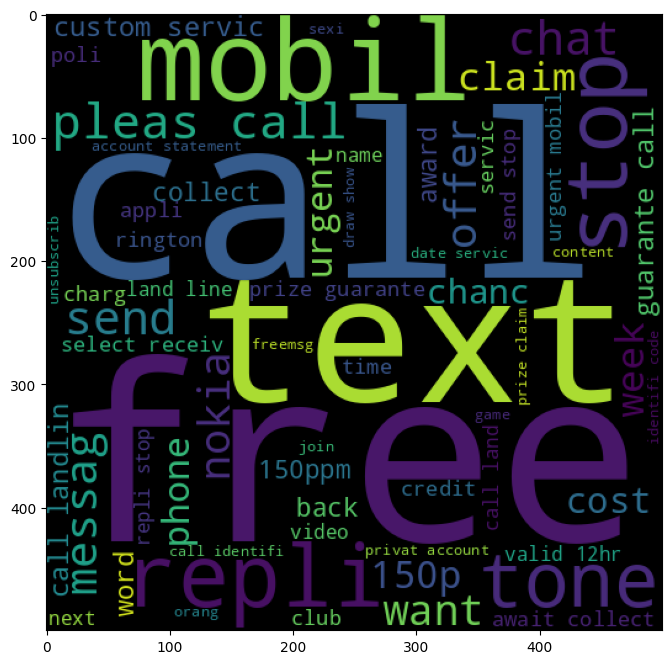

In [40]:
# Visualize the most frequently spam words
plt.figure(figsize = (12,8))
spam_words=wc.generate(df[df['output']==1]['text_transform'].str.cat(sep=" "))
plt.imshow(spam_words)
plt.show()

In [41]:
spam_corpus=[]
for msg in df[df['output']==1]['text_transform'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        
        
# get the 50 most frequent words in spam emails/SMS
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(50))

,0,1
0,call,320
1,free,189
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


In [42]:
ham_corpus=[]
for msg in df[df['output']==0]['text_transform'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
        
        
# get the 50 most frequent words in ham emails/SMS        
from collections import Counter
pd.DataFrame(Counter(ham_corpus).most_common(50))

,0,1
0,u,871
1,go,401
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,272
7,got,236
8,like,234
9,know,234


# Model Building

* CountVectorizer: module in scikit-learn, used to convert a collection of text documents to a matrix of token counts.

* TfidfVectorizer: module in scikit-learn. It converts a collection of text documents to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

In [43]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

#feature selection
X = tfidf.fit_transform(df['text_transform']).toarray()
y=df['output'].values

#  Split the data to train and testing set

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1,stratify=y,shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4135, 3000)
Shape of y_train: (4135,)
Shape of X_test: (1034, 3000)
Shape of y_test: (1034,)


# Training and Evaluation
# Model 1: MultinomialNB

0.9777562862669246
[[902   1]
 [ 22 109]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.83      0.90       131

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034



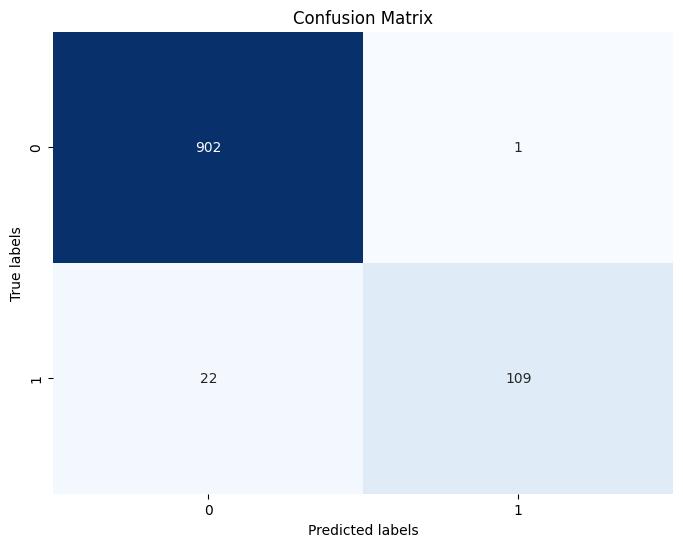

In [45]:
mnb=MultinomialNB()

mnb.fit(X_train,y_train)
y_pred_mnb=mnb.predict(X_test)

print(accuracy_score(y_test,y_pred_mnb))
print(confusion_matrix(y_test,y_pred_mnb))
print(classification_report(y_test,y_pred_mnb))

cm = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Conclusion of model 1
- The model is highly effective at correctly identifying class 0 instances, almost perfectly.

- While the model is good at predicting class 1 instances, it misses some actual positives, resulting in lower recall for class 1

# Model 2: GaussianNB

0.8646034816247582
[[777 126]
 [ 14 117]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       903
           1       0.48      0.89      0.63       131

    accuracy                           0.86      1034
   macro avg       0.73      0.88      0.77      1034
weighted avg       0.92      0.86      0.88      1034



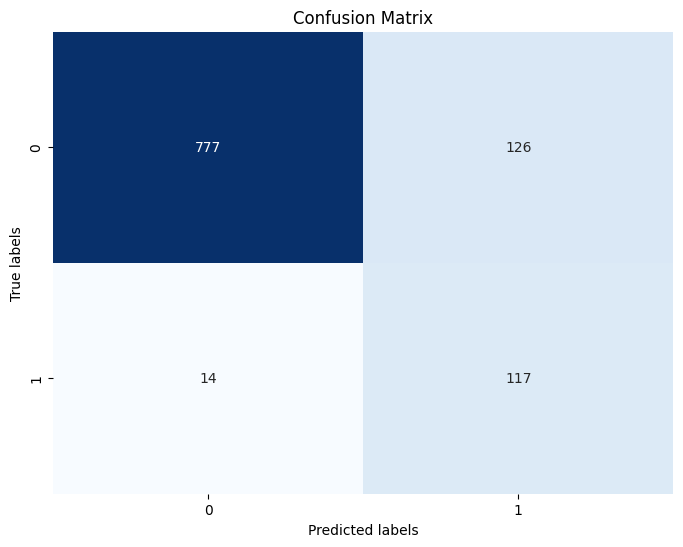

In [46]:
gnb=GaussianNB()

gnb.fit(X_train,y_train)
y_pred_gnb=gnb.predict(X_test)

print(accuracy_score(y_test,y_pred_gnb))
print(confusion_matrix(y_test,y_pred_gnb))
print(classification_report(y_test,y_pred_gnb))

cm = confusion_matrix(y_test, y_pred_gnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Conclusion for Model 2:
- Class 0: The model is very good at predicting class 0, with high precision and good recall, leading to a high F1-score.

- Class 1: The model is good at identifying actual class 1 instances (high recall) but struggles with false positives,   resulting in low precision and a lower F1-score.

# Model 3: BernoulliNB

0.9816247582205029
[[901   2]
 [ 17 114]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.98      0.87      0.92       131

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



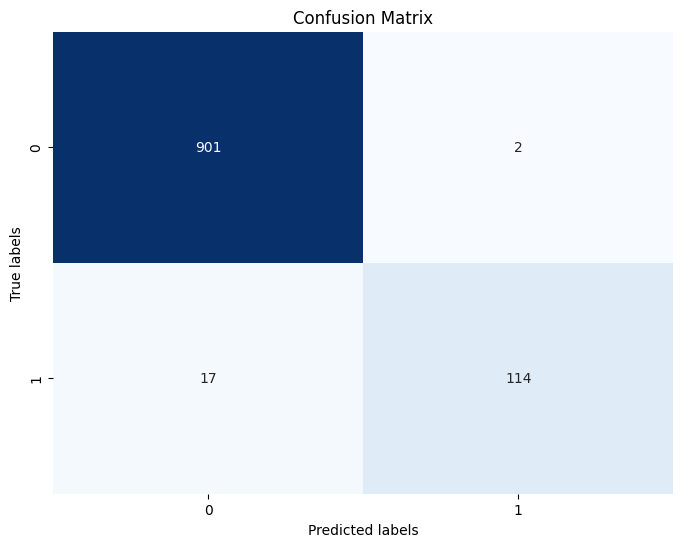

In [47]:
bnb=BernoulliNB()


bnb.fit(X_train,y_train)
y_pred_bnb=bnb.predict(X_test)

print(accuracy_score(y_test,y_pred_bnb))
print(confusion_matrix(y_test,y_pred_bnb))
print(classification_report(y_test,y_pred_bnb))

cm = confusion_matrix(y_test, y_pred_bnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# After the Training and Evaluation the best performing Model was BernoulliNB with and accuracy of 0.9816247582205029 indicates that the model is highly accurate across both classes.
# The model shows strong performance metrics across precision, recall, and F1-Score, indicating its effectiveness in classifying instances from both classes.